# Cross-Modality Correlation: 10x vs MERFISH — Thalamus & Claustrum

This notebook compares neuromodulator receptor expression between **10x snRNA-seq**
and **MERFISH spatial transcriptomics** for the **thalamus (TH)** and **claustrum (CLA)**,
analogous to the BLA/mPFC cross-modality validation.

### Shared Genes (11 of 28)
- **Serotonin**: Htr1b, Htr1d, Htr2a, Htr3a, Htr7
- **Norepinephrine**: Adra1a, Adra1b
- **Dopamine**: Drd1, Drd2, Drd3, Drd5

### Key Caveats
- **TH 10x**: Whole thalamus dissection (261K cells, many classes including hypothalamic contaminants)
- **TH MERFISH**: CCF-parcellated to 15 specific nuclei (50K cells)
- **CLA 10x**: CTXsp dissection with CLA-specific excitatory + shared interneurons (29K cells)
- **CLA MERFISH**: CCF-parcellated CLA + EPd (11K cells)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
import re

## 1. Load Pre-Extracted CSVs

In [2]:
# Thalamus 10x
th_10x_expr = pd.read_csv('th_10x_expression.csv', index_col=0)
th_10x_meta = pd.read_csv('th_10x_metadata.csv', index_col=0)

# Thalamus MERFISH
th_mer_expr = pd.read_csv('th_merfish_expression.csv', index_col=0)
th_mer_meta = pd.read_csv('th_merfish_metadata.csv', index_col=0)

# CLA 10x
cla_10x_neur = pd.read_csv('cla_10x_neuronal_expression.csv', index_col=0)
cla_10x_glia = pd.read_csv('cla_10x_glia_expression.csv', index_col=0)
cla_10x_expr = pd.concat([cla_10x_neur, cla_10x_glia])
cla_10x_meta = pd.read_csv('cla_10x_metadata.csv', index_col=0)

# CLA MERFISH
cla_mer_expr = pd.read_csv('cla_merfish_expression.csv', index_col=0)
cla_mer_meta = pd.read_csv('cla_merfish_metadata.csv', index_col=0)

print('Loaded datasets:')
print(f'  TH 10x:      {len(th_10x_expr):,} cells, {th_10x_expr.shape[1]} genes')
print(f'  TH MERFISH:   {len(th_mer_expr):,} cells, {th_mer_expr.shape[1]} genes')
print(f'  CLA 10x:     {len(cla_10x_expr):,} cells, {cla_10x_expr.shape[1]} genes')
print(f'  CLA MERFISH:  {len(cla_mer_expr):,} cells, {cla_mer_expr.shape[1]} genes')

Loaded datasets:
  TH 10x:      259,327 cells, 28 genes
  TH MERFISH:   50,282 cells, 11 genes
  CLA 10x:     53,972 cells, 28 genes
  CLA MERFISH:  8,932 cells, 11 genes


## 2. Compute Per-Subclass Summary Statistics

For each modality and region, compute mean expression and fraction expressing
per subclass per gene, then restrict to 11 shared genes and shared subclasses.

In [3]:
shared_genes = ['Htr1b', 'Htr1d', 'Htr2a', 'Htr3a', 'Htr7',
                'Adra1a', 'Adra1b',
                'Drd1', 'Drd2', 'Drd3', 'Drd5']

def strip_prefix(name):
    return re.sub(r'^\d+\s+', '', str(name))

def compute_stats(expr_df, meta_df, genes, min_cells=30):
    """Compute mean expression and fraction expressing per subclass."""
    common = expr_df.index.intersection(meta_df.index)
    available_genes = [g for g in genes if g in expr_df.columns]
    expr = expr_df.loc[common, available_genes].copy()
    meta = meta_df.loc[common].copy()
    meta['subclass_short'] = meta['subclass'].apply(strip_prefix)
    expr['subclass'] = meta['subclass_short'].values
    
    # Filter to subclasses with enough cells
    sc_counts = expr.groupby('subclass').size()
    valid_sc = sc_counts[sc_counts >= min_cells].index
    expr = expr[expr['subclass'].isin(valid_sc)]
    
    mean_expr = expr.groupby('subclass')[available_genes].mean()
    frac_expr = expr.groupby('subclass')[available_genes].apply(lambda x: (x > 0).mean())
    
    return mean_expr, frac_expr

# Compute stats for each dataset
th_10x_mean, th_10x_frac = compute_stats(th_10x_expr, th_10x_meta, shared_genes, min_cells=50)
th_mer_mean, th_mer_frac = compute_stats(th_mer_expr, th_mer_meta, shared_genes, min_cells=30)
cla_10x_mean, cla_10x_frac = compute_stats(cla_10x_expr, cla_10x_meta, shared_genes, min_cells=50)
cla_mer_mean, cla_mer_frac = compute_stats(cla_mer_expr, cla_mer_meta, shared_genes, min_cells=30)

print('Per-subclass stats:')
print(f'  TH 10x:     {len(th_10x_mean)} subclasses')
print(f'  TH MERFISH:  {len(th_mer_mean)} subclasses')
print(f'  CLA 10x:    {len(cla_10x_mean)} subclasses')
print(f'  CLA MERFISH: {len(cla_mer_mean)} subclasses')

Per-subclass stats:
  TH 10x:     39 subclasses
  TH MERFISH:  26 subclasses
  CLA 10x:    12 subclasses
  CLA MERFISH: 18 subclasses


In [4]:
# Find shared subclasses between modalities
th_shared_sc = sorted(set(th_10x_mean.index) & set(th_mer_mean.index))
cla_shared_sc = sorted(set(cla_10x_mean.index) & set(cla_mer_mean.index))

print(f'TH shared subclasses ({len(th_shared_sc)}):')
for sc in th_shared_sc:
    n10x = th_10x_meta[th_10x_meta['subclass'].apply(strip_prefix) == sc].shape[0]
    nmer = th_mer_meta[th_mer_meta['subclass'].apply(strip_prefix) == sc].shape[0]
    print(f'  {sc:50s} 10x={n10x:>6,}  MER={nmer:>5,}')

print(f'\nCLA shared subclasses ({len(cla_shared_sc)}):')
for sc in cla_shared_sc:
    n10x = cla_10x_meta[cla_10x_meta['subclass'].apply(strip_prefix) == sc].shape[0]
    nmer = cla_mer_meta[cla_mer_meta['subclass'].apply(strip_prefix) == sc].shape[0]
    print(f'  {sc:50s} 10x={n10x:>6,}  MER={nmer:>5,}')

# Align to shared subclasses
th_10x_mean_s = th_10x_mean.loc[th_shared_sc]
th_10x_frac_s = th_10x_frac.loc[th_shared_sc]
th_mer_mean_s = th_mer_mean.loc[th_shared_sc]
th_mer_frac_s = th_mer_frac.loc[th_shared_sc]

cla_10x_mean_s = cla_10x_mean.loc[cla_shared_sc]
cla_10x_frac_s = cla_10x_frac.loc[cla_shared_sc]
cla_mer_mean_s = cla_mer_mean.loc[cla_shared_sc]
cla_mer_frac_s = cla_mer_frac.loc[cla_shared_sc]

TH shared subclasses (22):


  AD Serpinb7 Glut                                   10x=   716  MER=1,039


  APN C1ql4 Glut                                     10x= 1,068  MER=   31


  AV Col27a1 Glut                                    10x= 7,321  MER=1,307


  Astro-NT NN                                        10x=11,316  MER=6,379


  Astroependymal NN                                  10x=   322  MER=  362


  CM-IAD-CL-PCN Sema5b Glut                          10x=13,590  MER=3,119


  Endo NN                                            10x= 4,342  MER=3,463


  Ependymal NN                                       10x=   324  MER=  603


  LGv-ZI Otx2 Gaba                                   10x= 4,380  MER=   48


  Microglia NN                                       10x= 2,368  MER=  440


  OPC NN                                             10x=12,064  MER=  824


  Oligo NN                                           10x=59,446  MER=7,507


  PF Fzd5 Glut                                       10x= 6,626  MER=2,944


  PVT-PT Ntrk1 Glut                                  10x= 9,854  MER=3,175


  Peri NN                                            10x= 1,716  MER=  733


  RE-Xi Nox4 Glut                                    10x= 5,450  MER=2,149


  RT-ZI Gnb3 Gaba                                    10x= 7,452  MER=6,879


  SMC NN                                             10x=   912  MER=  255


  SPA-SPFm-SPFp-POL-PIL-PoT Sp9 Glut                 10x=10,752  MER=  194


  TH Prkcd Grin2c Glut                               10x=68,125  MER=7,466


  VLMC NN                                            10x=   463  MER=  294


  ZI Pax6 Gaba                                       10x= 3,702  MER=   99

CLA shared subclasses (11):
  Astro-TE NN                                        10x=19,140  MER=1,048
  CLA-EPd-CTX Car3 Glut                              10x= 4,022  MER=1,499
  IT EP-CLA Glut                                     10x=14,775  MER=2,391
  Lamp5 Gaba                                         10x= 1,208  MER=   49
  Lamp5 Lhx6 Gaba                                    10x=   678  MER=   49


  Microglia NN                                       10x= 6,164  MER=  216
  Pvalb Gaba                                         10x= 1,343  MER=  323
  Sncg Gaba                                          10x= 1,086  MER=   62
  Sst Chodl Gaba                                     10x=   448  MER=   35
  Sst Gaba                                           10x= 2,609  MER=  394


  Vip Gaba                                           10x= 2,081  MER=   40


## 3. Overall Scatter: 10x vs MERFISH

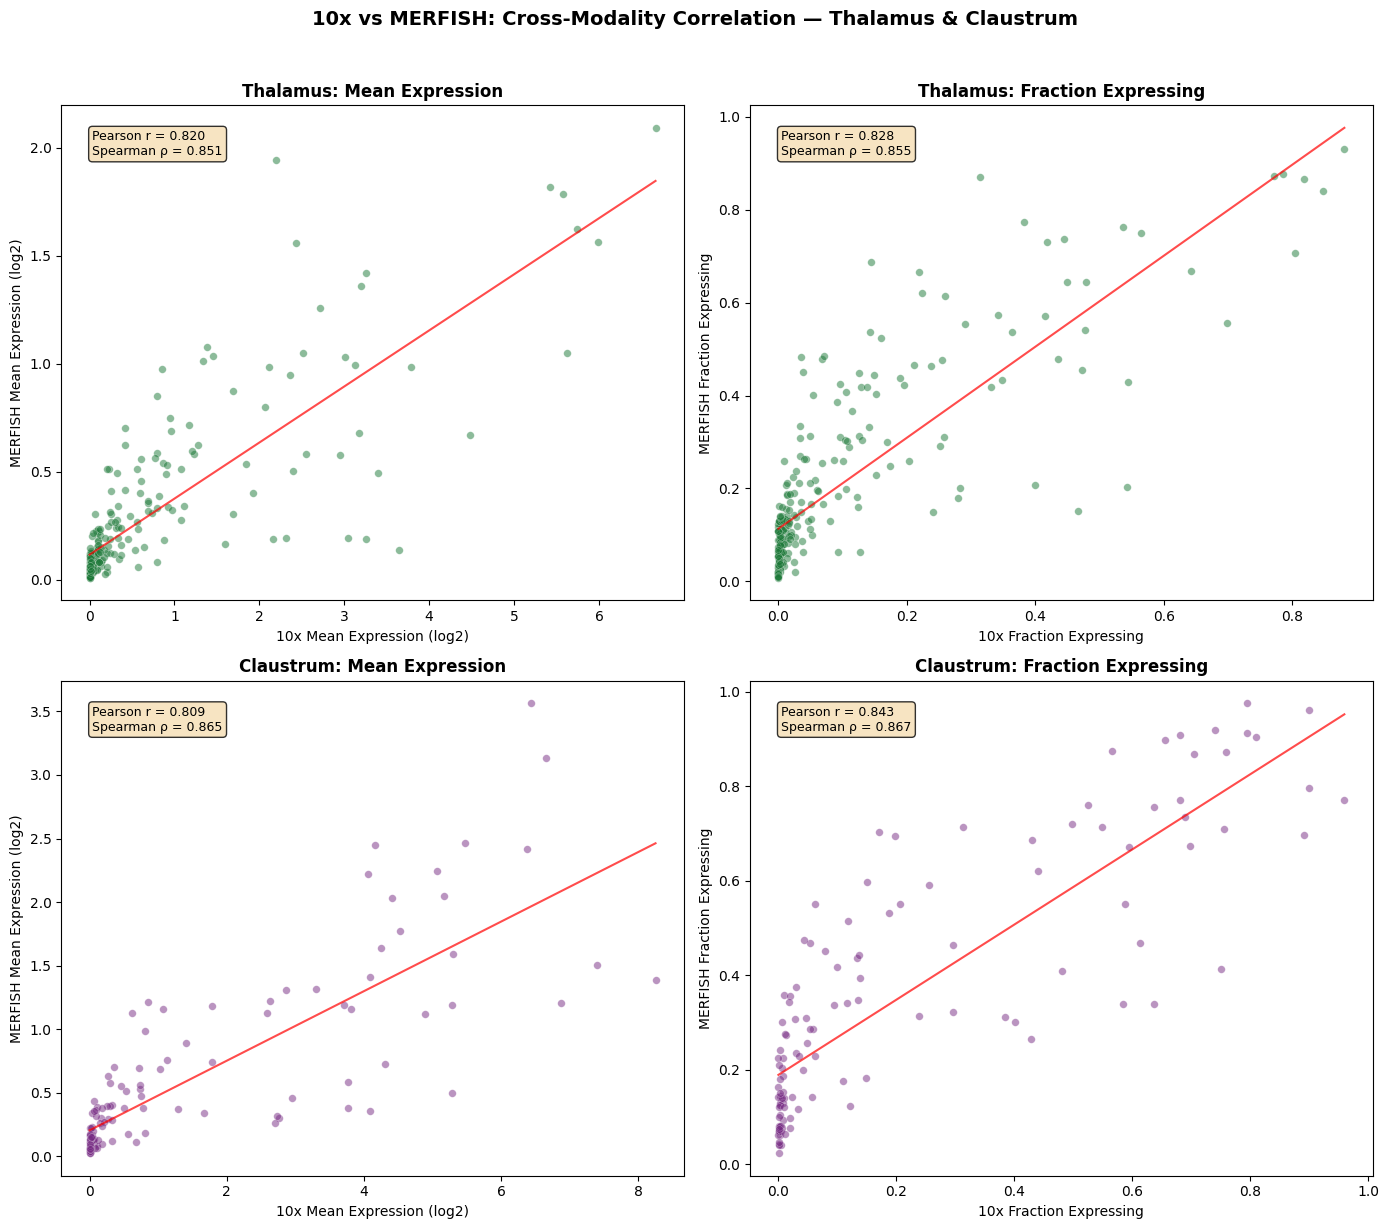

Saved: xmodal_scatter_TH_CLA.png


In [5]:
def scatter_correlation(ax, x, y, xlabel, ylabel, title, color='steelblue'):
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    ax.scatter(x, y, alpha=0.5, s=30, c=color, edgecolors='white', linewidth=0.3)
    if len(x) > 2:
        r_pearson, _ = stats.pearsonr(x, y)
        r_spearman, _ = stats.spearmanr(x, y)
        z = np.polyfit(x, y, 1)
        xline = np.linspace(x.min(), x.max(), 100)
        ax.plot(xline, np.polyval(z, xline), 'r-', alpha=0.7, linewidth=1.5)
        ax.text(0.05, 0.95, f'Pearson r = {r_pearson:.3f}\nSpearman \u03c1 = {r_spearman:.3f}',
                transform=ax.transAxes, va='top', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title, fontweight='bold')

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

scatter_correlation(axes[0, 0],
    th_10x_mean_s.values.flatten(), th_mer_mean_s.values.flatten(),
    '10x Mean Expression (log2)', 'MERFISH Mean Expression (log2)',
    'Thalamus: Mean Expression', color='#1b7837')
scatter_correlation(axes[0, 1],
    th_10x_frac_s.values.flatten(), th_mer_frac_s.values.flatten(),
    '10x Fraction Expressing', 'MERFISH Fraction Expressing',
    'Thalamus: Fraction Expressing', color='#1b7837')
scatter_correlation(axes[1, 0],
    cla_10x_mean_s.values.flatten(), cla_mer_mean_s.values.flatten(),
    '10x Mean Expression (log2)', 'MERFISH Mean Expression (log2)',
    'Claustrum: Mean Expression', color='#762a83')
scatter_correlation(axes[1, 1],
    cla_10x_frac_s.values.flatten(), cla_mer_frac_s.values.flatten(),
    '10x Fraction Expressing', 'MERFISH Fraction Expressing',
    'Claustrum: Fraction Expressing', color='#762a83')

plt.suptitle('10x vs MERFISH: Cross-Modality Correlation — Thalamus & Claustrum',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('xmodal_scatter_TH_CLA.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: xmodal_scatter_TH_CLA.png')

## 4. Per-Gene Correlation

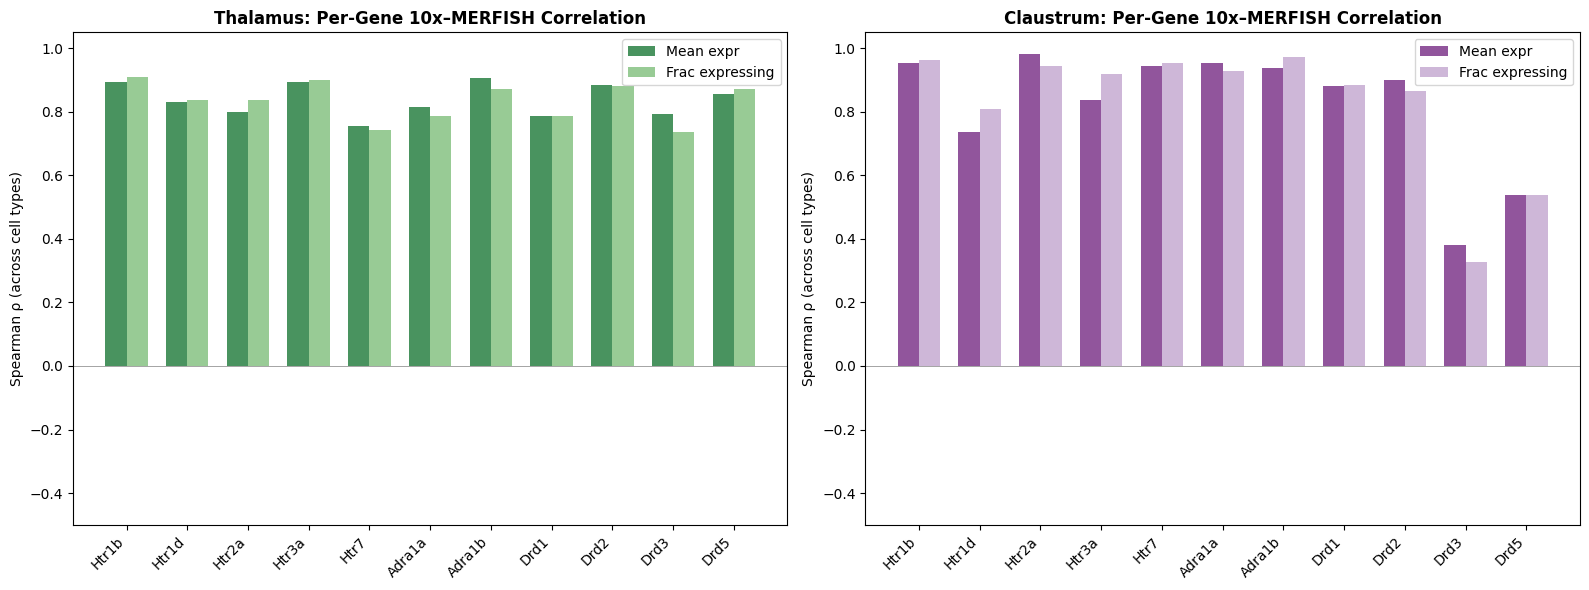

Saved: xmodal_per_gene_TH_CLA.png

Thalamus per-gene correlations:


,rho_mean,p_mean,rho_frac,p_frac
gene,,,,
Htr1b,0.895,0.0,0.910,0.0
Htr1d,0.832,0.0,0.836,0.0
Htr2a,0.800,0.0,0.837,0.0
Htr3a,0.893,0.0,0.901,0.0
Htr7,0.756,0.0,0.743,0.0
Adra1a,0.816,0.0,0.785,0.0
Adra1b,0.907,0.0,0.872,0.0
Drd1,0.787,0.0,0.785,0.0
Drd2,0.886,0.0,0.882,0.0



Claustrum per-gene correlations:


,rho_mean,p_mean,rho_frac,p_frac
gene,,,,
Htr1b,0.955,0.000,0.964,0.000
Htr1d,0.736,0.010,0.809,0.003
Htr2a,0.982,0.000,0.945,0.000
Htr3a,0.836,0.001,0.918,0.000
Htr7,0.945,0.000,0.955,0.000
Adra1a,0.955,0.000,0.927,0.000
Adra1b,0.936,0.000,0.973,0.000
Drd1,0.882,0.000,0.884,0.000
Drd2,0.900,0.000,0.866,0.001


In [6]:
def per_gene_correlations(mean_10x, mean_mer, frac_10x, frac_mer, genes):
    results = []
    for g in genes:
        r_mean, p_mean = stats.spearmanr(mean_10x[g], mean_mer[g])
        r_frac, p_frac = stats.spearmanr(frac_10x[g], frac_mer[g])
        results.append({'gene': g, 'rho_mean': r_mean, 'p_mean': p_mean,
                        'rho_frac': r_frac, 'p_frac': p_frac})
    return pd.DataFrame(results).set_index('gene')

th_gene_corr = per_gene_correlations(th_10x_mean_s, th_mer_mean_s,
                                      th_10x_frac_s, th_mer_frac_s, shared_genes)
cla_gene_corr = per_gene_correlations(cla_10x_mean_s, cla_mer_mean_s,
                                       cla_10x_frac_s, cla_mer_frac_s, shared_genes)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
x = np.arange(len(shared_genes))
width = 0.35

axes[0].bar(x - width/2, th_gene_corr['rho_mean'], width, label='Mean expr', color='#1b7837', alpha=0.8)
axes[0].bar(x + width/2, th_gene_corr['rho_frac'], width, label='Frac expressing', color='#7fbf7b', alpha=0.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(shared_genes, rotation=45, ha='right')
axes[0].set_ylabel('Spearman \u03c1 (across cell types)')
axes[0].set_title('Thalamus: Per-Gene 10x\u2013MERFISH Correlation', fontweight='bold')
axes[0].legend()
axes[0].axhline(y=0, color='grey', linewidth=0.5)
axes[0].set_ylim(-0.5, 1.05)

axes[1].bar(x - width/2, cla_gene_corr['rho_mean'], width, label='Mean expr', color='#762a83', alpha=0.8)
axes[1].bar(x + width/2, cla_gene_corr['rho_frac'], width, label='Frac expressing', color='#c2a5cf', alpha=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(shared_genes, rotation=45, ha='right')
axes[1].set_ylabel('Spearman \u03c1 (across cell types)')
axes[1].set_title('Claustrum: Per-Gene 10x\u2013MERFISH Correlation', fontweight='bold')
axes[1].legend()
axes[1].axhline(y=0, color='grey', linewidth=0.5)
axes[1].set_ylim(-0.5, 1.05)

plt.tight_layout()
plt.savefig('xmodal_per_gene_TH_CLA.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: xmodal_per_gene_TH_CLA.png')

print('\nThalamus per-gene correlations:')
display(th_gene_corr.round(3))
print('\nClaustrum per-gene correlations:')
display(cla_gene_corr.round(3))

## 5. Per-Cell-Type Correlation

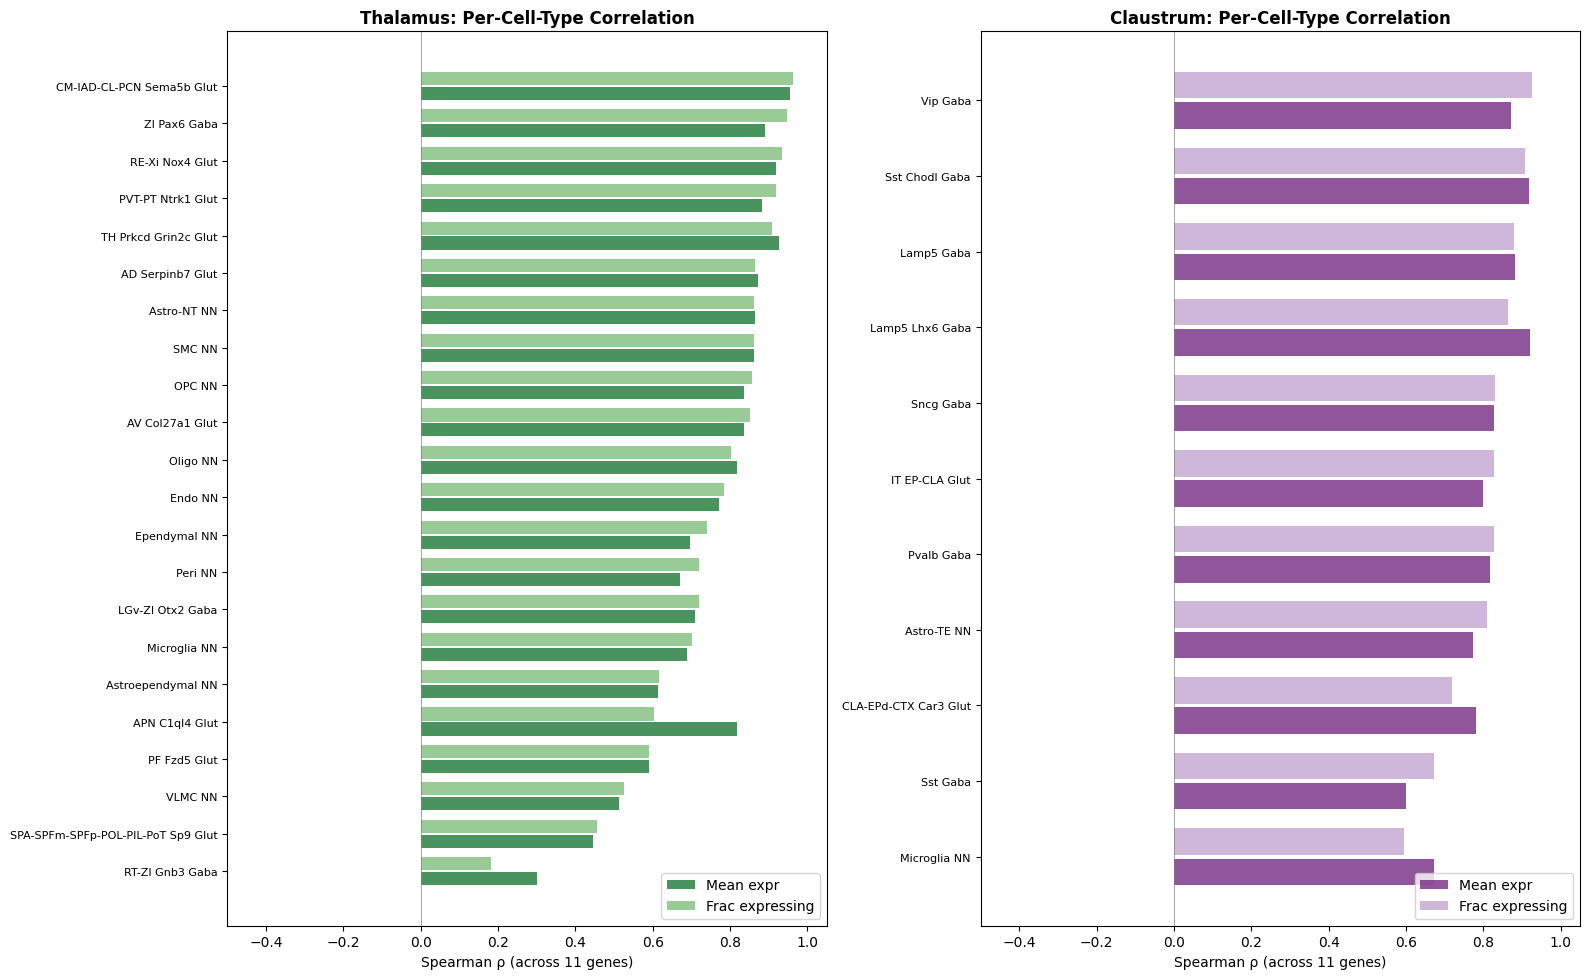

Saved: xmodal_per_celltype_TH_CLA.png

Thalamus per-cell-type correlations:


,rho_mean,p_mean,rho_frac,p_frac
subclass,,,,
CM-IAD-CL-PCN Sema5b Glut,0.955,0.000,0.964,0.000
ZI Pax6 Gaba,0.891,0.000,0.948,0.000
RE-Xi Nox4 Glut,0.918,0.000,0.934,0.000
PVT-PT Ntrk1 Glut,0.882,0.000,0.918,0.000
TH Prkcd Grin2c Glut,0.927,0.000,0.909,0.000
AD Serpinb7 Glut,0.873,0.000,0.864,0.001
Astro-NT NN,0.864,0.001,0.861,0.001
SMC NN,0.861,0.001,0.861,0.001
OPC NN,0.836,0.001,0.856,0.001



Claustrum per-cell-type correlations:


,rho_mean,p_mean,rho_frac,p_frac
subclass,,,,
Vip Gaba,0.873,0.000,0.925,0.000
Sst Chodl Gaba,0.918,0.000,0.909,0.000
Lamp5 Gaba,0.882,0.000,0.879,0.000
Lamp5 Lhx6 Gaba,0.920,0.000,0.863,0.001
Sncg Gaba,0.827,0.002,0.831,0.002
IT EP-CLA Glut,0.800,0.003,0.827,0.002
Pvalb Gaba,0.818,0.002,0.827,0.002
Astro-TE NN,0.773,0.005,0.809,0.003
CLA-EPd-CTX Car3 Glut,0.782,0.004,0.718,0.013


In [7]:
def per_celltype_correlations(mean_10x, mean_mer, frac_10x, frac_mer):
    results = []
    for sc in mean_10x.index:
        r_mean, p_mean = stats.spearmanr(mean_10x.loc[sc], mean_mer.loc[sc])
        r_frac, p_frac = stats.spearmanr(frac_10x.loc[sc], frac_mer.loc[sc])
        results.append({'subclass': sc, 'rho_mean': r_mean, 'p_mean': p_mean,
                        'rho_frac': r_frac, 'p_frac': p_frac})
    return pd.DataFrame(results).set_index('subclass')

th_ct_corr = per_celltype_correlations(th_10x_mean_s, th_mer_mean_s,
                                        th_10x_frac_s, th_mer_frac_s)
cla_ct_corr = per_celltype_correlations(cla_10x_mean_s, cla_mer_mean_s,
                                         cla_10x_frac_s, cla_mer_frac_s)

fig, axes = plt.subplots(1, 2, figsize=(16, max(7, max(len(th_ct_corr), len(cla_ct_corr)) * 0.45)))

# TH
th_ct_sorted = th_ct_corr.sort_values('rho_frac', ascending=True)
y = np.arange(len(th_ct_sorted))
axes[0].barh(y - 0.2, th_ct_sorted['rho_mean'], 0.35, label='Mean expr', color='#1b7837', alpha=0.8)
axes[0].barh(y + 0.2, th_ct_sorted['rho_frac'], 0.35, label='Frac expressing', color='#7fbf7b', alpha=0.8)
axes[0].set_yticks(y)
axes[0].set_yticklabels(th_ct_sorted.index, fontsize=8)
axes[0].set_xlabel('Spearman \u03c1 (across 11 genes)')
axes[0].set_title('Thalamus: Per-Cell-Type Correlation', fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].axvline(x=0, color='grey', linewidth=0.5)
axes[0].set_xlim(-0.5, 1.05)

# CLA
cla_ct_sorted = cla_ct_corr.sort_values('rho_frac', ascending=True)
y = np.arange(len(cla_ct_sorted))
axes[1].barh(y - 0.2, cla_ct_sorted['rho_mean'], 0.35, label='Mean expr', color='#762a83', alpha=0.8)
axes[1].barh(y + 0.2, cla_ct_sorted['rho_frac'], 0.35, label='Frac expressing', color='#c2a5cf', alpha=0.8)
axes[1].set_yticks(y)
axes[1].set_yticklabels(cla_ct_sorted.index, fontsize=8)
axes[1].set_xlabel('Spearman \u03c1 (across 11 genes)')
axes[1].set_title('Claustrum: Per-Cell-Type Correlation', fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].axvline(x=0, color='grey', linewidth=0.5)
axes[1].set_xlim(-0.5, 1.05)

plt.tight_layout()
plt.savefig('xmodal_per_celltype_TH_CLA.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: xmodal_per_celltype_TH_CLA.png')

print('\nThalamus per-cell-type correlations:')
display(th_ct_corr.sort_values('rho_frac', ascending=False).round(3))
print('\nClaustrum per-cell-type correlations:')
display(cla_ct_corr.sort_values('rho_frac', ascending=False).round(3))

## 6. Rank Comparison and Agreement

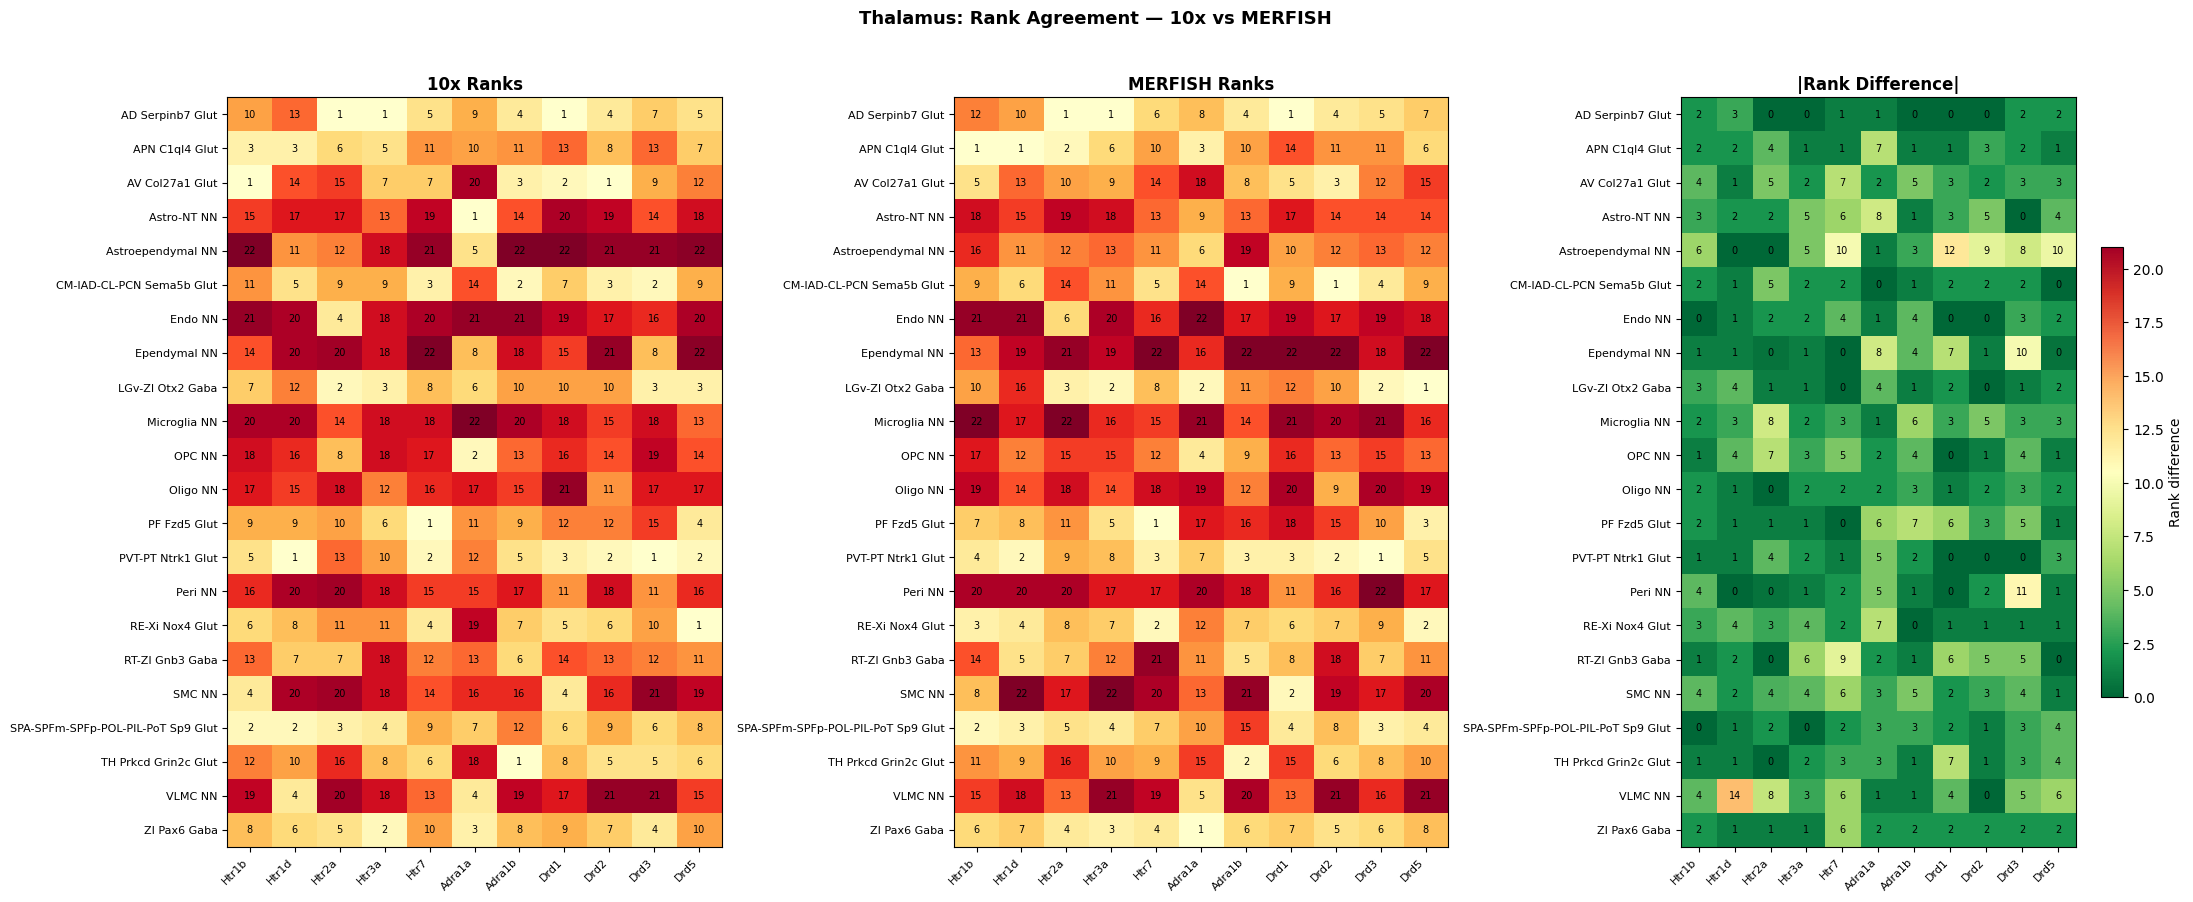

Saved: xmodal_rank_agreement_TH.png


In [8]:
def compute_ranks(frac_df):
    return frac_df.rank(ascending=False, method='average')

def plot_rank_agreement_heatmap(ranks_10x, ranks_mer, genes, region, filename, color_10x='YlOrRd'):
    rank_diff = (ranks_10x[genes] - ranks_mer[genes]).abs()
    n_ct = len(rank_diff)
    
    fig, axes = plt.subplots(1, 3, figsize=(22, max(5, n_ct * 0.4)),
                             gridspec_kw={'width_ratios': [1, 1, 1]})
    
    for ax_idx, (data, title) in enumerate([
        (ranks_10x[genes], '10x Ranks'),
        (ranks_mer[genes], 'MERFISH Ranks'),
        (rank_diff, '|Rank Difference|')
    ]):
        cmap = 'RdYlGn_r' if ax_idx == 2 else 'YlOrRd'
        vmax = n_ct - 1 if ax_idx == 2 else n_ct
        vmin = 0 if ax_idx == 2 else 1
        im = axes[ax_idx].imshow(data.values, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
        axes[ax_idx].set_title(title, fontweight='bold')
        axes[ax_idx].set_yticks(range(n_ct))
        axes[ax_idx].set_yticklabels(data.index, fontsize=8)
        axes[ax_idx].set_xticks(range(len(genes)))
        axes[ax_idx].set_xticklabels(genes, rotation=45, ha='right', fontsize=8)
        for i in range(n_ct):
            for j in range(len(genes)):
                val = data.iloc[i, j]
                axes[ax_idx].text(j, i, f'{val:.0f}', ha='center', va='center', fontsize=7, color='black')
    
    plt.colorbar(im, ax=axes[2], shrink=0.6, label='Rank difference')
    plt.suptitle(f'{region}: Rank Agreement — 10x vs MERFISH', fontsize=13, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Saved: {filename}')
    return rank_diff

# TH
th_ranks_10x = compute_ranks(th_10x_frac_s)
th_ranks_mer = compute_ranks(th_mer_frac_s)
th_rank_diff = plot_rank_agreement_heatmap(
    th_ranks_10x, th_ranks_mer, shared_genes, 'Thalamus', 'xmodal_rank_agreement_TH.png')

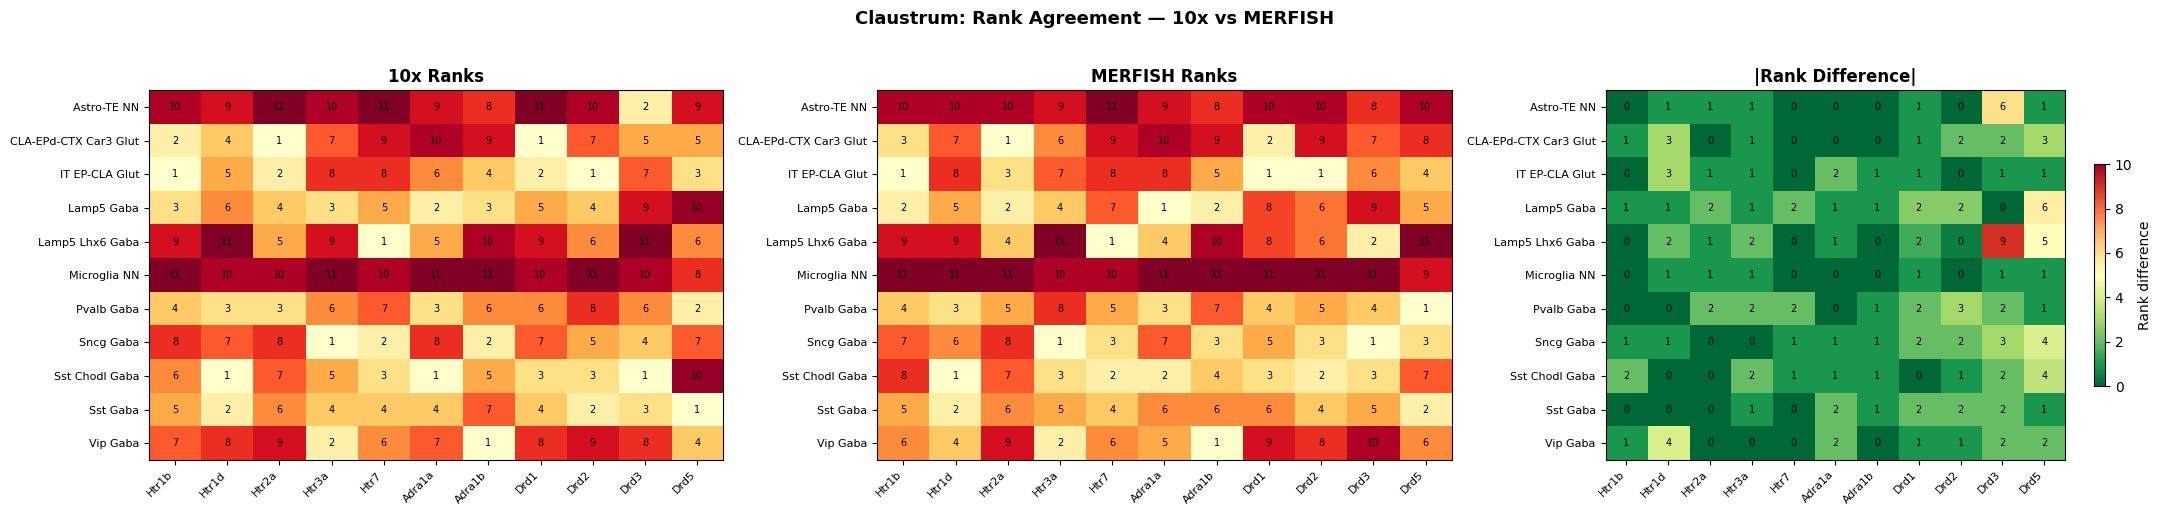

Saved: xmodal_rank_agreement_CLA.png


In [9]:
# CLA
cla_ranks_10x = compute_ranks(cla_10x_frac_s)
cla_ranks_mer = compute_ranks(cla_mer_frac_s)
cla_rank_diff = plot_rank_agreement_heatmap(
    cla_ranks_10x, cla_ranks_mer, shared_genes, 'Claustrum', 'xmodal_rank_agreement_CLA.png')

## 7. Consensus Rankings

In [10]:
def consensus_rankings(ranks_10x, ranks_mer, rank_diff, genes, shared_sc, region):
    consensus = (ranks_10x[genes] + ranks_mer[genes]) / 2
    n_ct = len(shared_sc)
    max_diff = n_ct - 1
    confidence = 1 - (rank_diff[genes] / max_diff)
    
    summary_rows = []
    for gene in genes:
        gene_consensus = consensus[gene].sort_values()
        gene_confidence = confidence[gene]
        for ct, cons_rank in gene_consensus.items():
            conf = gene_confidence[ct]
            r10x = int(ranks_10x.loc[ct, gene])
            rmer = int(ranks_mer.loc[ct, gene])
            summary_rows.append({
                'region': region, 'gene': gene, 'cell_type': ct,
                'consensus_rank': cons_rank,
                'rank_10x': r10x, 'rank_merfish': rmer,
                'rank_diff': abs(r10x - rmer),
                'confidence': conf
            })
    return pd.DataFrame(summary_rows), consensus, confidence

th_summary, th_consensus, th_confidence = consensus_rankings(
    th_ranks_10x, th_ranks_mer, th_rank_diff, shared_genes, th_shared_sc, 'TH')
cla_summary, cla_consensus, cla_confidence = consensus_rankings(
    cla_ranks_10x, cla_ranks_mer, cla_rank_diff, shared_genes, cla_shared_sc, 'CLA')

/tmp/ipykernel_2141/3327005204.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ax.scatter(j, i, s=size, c=[plt.cm.get_cmap(cmap_name)(color_val)],


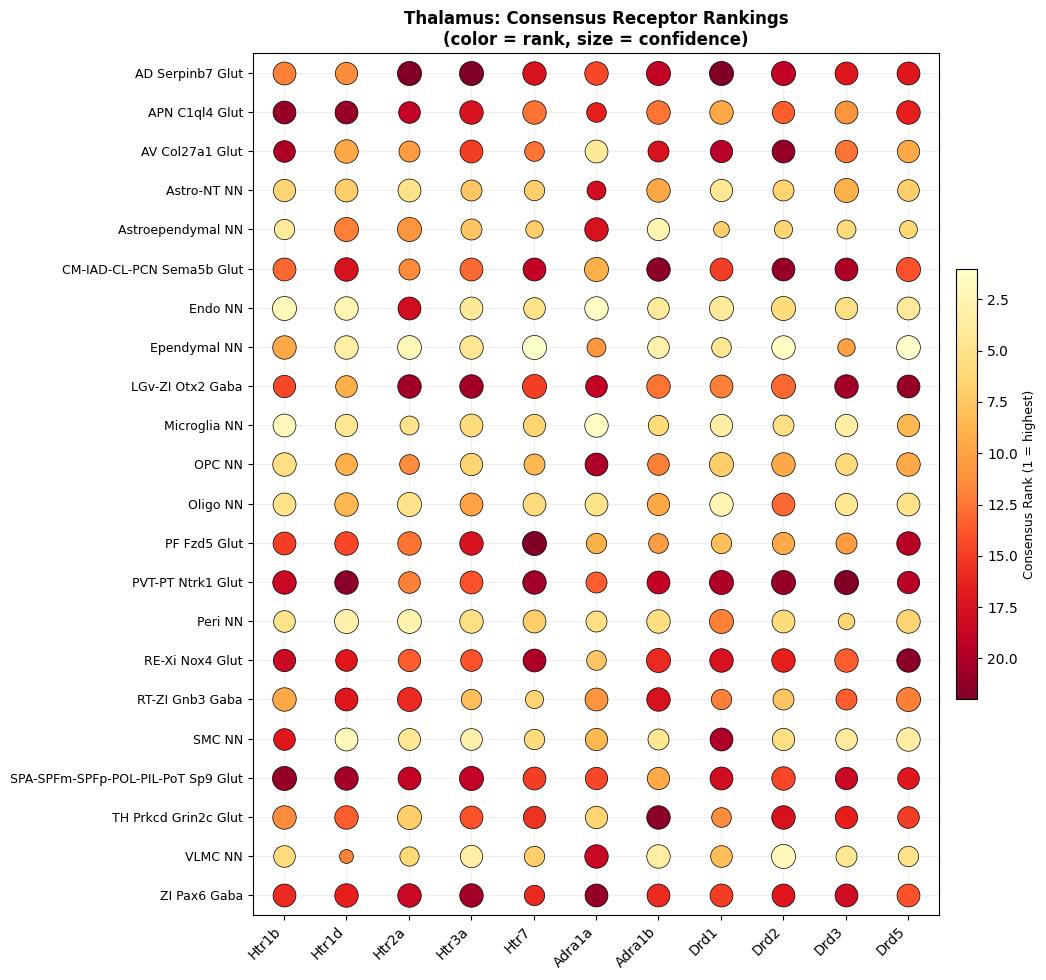

Saved: xmodal_consensus_TH.png


In [11]:
def plot_consensus_dotplot(consensus, confidence, genes, region, filename, cmap_name='YlOrRd'):
    cell_types = consensus.index.tolist()
    n_ct = len(cell_types)
    n_genes = len(genes)
    
    fig, ax = plt.subplots(figsize=(max(10, n_genes * 1.0), max(6, n_ct * 0.45)))
    
    for i, ct in enumerate(cell_types):
        for j, gene in enumerate(genes):
            rank_val = consensus.loc[ct, gene]
            conf_val = confidence.loc[ct, gene]
            size = max(20, conf_val * 300)
            color_val = 1 - (rank_val - 1) / (n_ct - 1)
            ax.scatter(j, i, s=size, c=[plt.cm.get_cmap(cmap_name)(color_val)],
                      edgecolors='black', linewidth=0.5, zorder=3)
    
    ax.set_xticks(range(n_genes))
    ax.set_xticklabels(genes, rotation=45, ha='right', fontsize=10)
    ax.set_yticks(range(n_ct))
    ax.set_yticklabels(cell_types, fontsize=9)
    ax.set_xlim(-0.5, n_genes - 0.5)
    ax.set_ylim(-0.5, n_ct - 0.5)
    ax.invert_yaxis()
    ax.grid(True, alpha=0.2)
    ax.set_title(f'{region}: Consensus Receptor Rankings\n(color = rank, size = confidence)',
                 fontweight='bold', fontsize=12)
    
    sm = plt.cm.ScalarMappable(cmap=cmap_name, norm=plt.Normalize(vmin=1, vmax=n_ct))
    cbar = plt.colorbar(sm, ax=ax, shrink=0.5, pad=0.02)
    cbar.set_label('Consensus Rank (1 = highest)', fontsize=9)
    cbar.ax.invert_yaxis()
    
    plt.tight_layout()
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Saved: {filename}')

plot_consensus_dotplot(th_consensus, th_confidence, shared_genes, 'Thalamus',
                       'xmodal_consensus_TH.png', 'YlOrRd')

/tmp/ipykernel_2141/3327005204.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ax.scatter(j, i, s=size, c=[plt.cm.get_cmap(cmap_name)(color_val)],


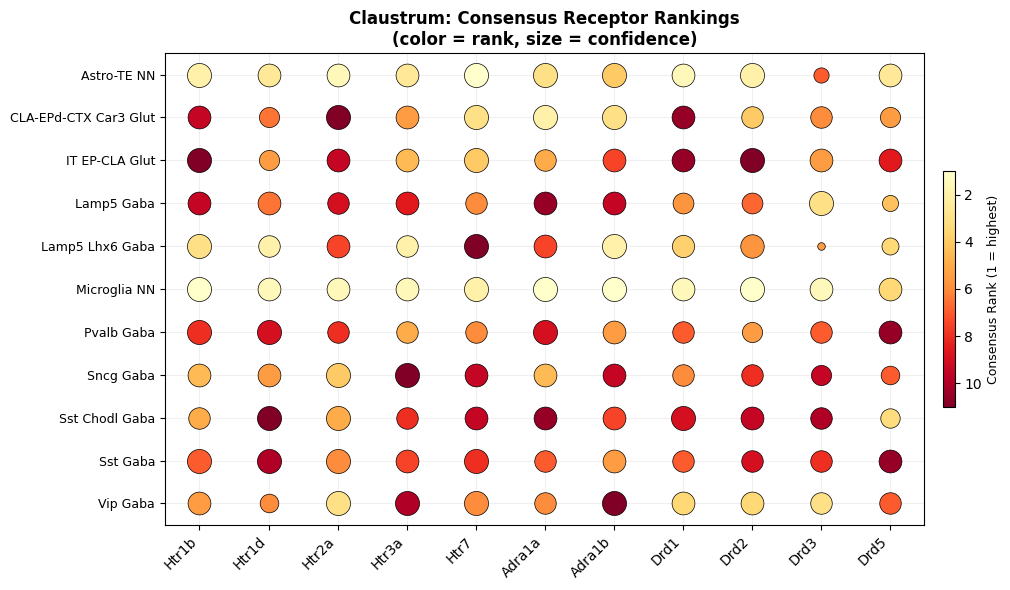

Saved: xmodal_consensus_CLA.png


In [12]:
plot_consensus_dotplot(cla_consensus, cla_confidence, shared_genes, 'Claustrum',
                       'xmodal_consensus_CLA.png', 'YlOrRd')

## 8. Summary: High-Confidence Rankings

In [13]:
all_rankings = pd.concat([th_summary, cla_summary])
all_rankings.to_csv('consensus_rankings_TH_CLA.csv', index=False)

print(f'Saved consensus_rankings_TH_CLA.csv: {len(all_rankings)} rows')

# High-confidence top rankings
for region in ['TH', 'CLA']:
    print(f'\n{"=" * 70}')
    print(f'{region}: High-confidence top-3 rankings (confidence >= 0.7, rank <= 3.0)')
    print(f'{"=" * 70}')
    top = all_rankings[(all_rankings['region'] == region) & 
                       (all_rankings['confidence'] >= 0.7) & 
                       (all_rankings['consensus_rank'] <= 3.0)]
    top_sorted = top.sort_values(['gene', 'consensus_rank'])
    for _, row in top_sorted.iterrows():
        print(f"  {row['gene']:8s}  {row['cell_type']:40s}  rank={row['consensus_rank']:.1f}  "
              f"(10x={row['rank_10x']}, MER={row['rank_merfish']})  conf={row['confidence']:.2f}")

Saved consensus_rankings_TH_CLA.csv: 363 rows

TH: High-confidence top-3 rankings (confidence >= 0.7, rank <= 3.0)
  Adra1a    ZI Pax6 Gaba                              rank=2.0  (10x=3, MER=1)  conf=0.90
  Adra1a    OPC NN                                    rank=3.0  (10x=2, MER=4)  conf=0.90
  Adra1b    CM-IAD-CL-PCN Sema5b Glut                 rank=1.5  (10x=2, MER=1)  conf=0.95
  Adra1b    TH Prkcd Grin2c Glut                      rank=1.5  (10x=1, MER=2)  conf=0.95
  Drd1      AD Serpinb7 Glut                          rank=1.0  (10x=1, MER=1)  conf=1.00
  Drd1      PVT-PT Ntrk1 Glut                         rank=3.0  (10x=3, MER=3)  conf=1.00
  Drd1      SMC NN                                    rank=3.0  (10x=4, MER=2)  conf=0.90
  Drd2      AV Col27a1 Glut                           rank=2.0  (10x=1, MER=3)  conf=0.90
  Drd2      CM-IAD-CL-PCN Sema5b Glut                 rank=2.0  (10x=3, MER=1)  conf=0.90
  Drd2      PVT-PT Ntrk1 Glut                         rank=2.0  (10x=2, MER